# Deep learning Physics Informed Neural networks

- We follow excellent book [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291) in splitting (very broadly) the field of Artificial Intelligence into **!Deep learning** and **Deep learning**
- In Python world a large subset of methed that fall under the former category (Support Vector Machines, K-Means, Random Forrests, ...) is provided by [Scikit-learn](https://scikit-learn.org/stable/), see also notebooks from previous editions of IN3110
- Here we will focus on **Deep learning** using Python library [PyTorch](https://pytorch.org/)

## Deep learning basics

Below we touch only the bare minimum of concepts. If you are curious about the topic see [Deep Learning book](https://www.deeplearningbook.org/)

### Networks

- Our aim is to learn an approximation to function $f$ mapping inputs $x\in\mathbb{R}^n$ to outputs $y\in\mathbb{R}^m$
- The function is represented by composition of simple nonlinear functions. For example, consider 

  $$
    u_0(x) = \rho(W_0\cdot x + b_0), W_0\in\mathbb{R}^{m_0 \times n}, b_0\in\mathbb{R}^{m_0}.
  $$
  
  Here $W_0$ is a (weight) matrix and $b_0$ is the vector of biases. We can control proporties of $u_0$ by adjusting 
  $W_0$, $b_0$
- Function $\rho$ is the source of non-linearity, e.g. $\rho(x) = \max(0, x)$ (so-called ReLU) or $\rho=\tanh$. Note that $\rho$ is applied component-wise to each element in the vector $x$
- Note that $u_0(x)\in\mathbb{R}^{m_0}$ and the function's output can be used as input to another function $u_1$ (defined analogously). By composing the functions this way we are adding _layers_/incresing the _depth_ of our network
  
  $$
    \text{NN}(x) = W_N \cdot u_{N-1}(\cdots u_2(u_1(u_0(x))) + b_N
  $$
  
  Note that we do not apply non-linearity in the last layer;it only has weigths $W_N\in\mathbb{R}^{m\times m_{N}}$ and bias $b_N\in\mathbb{R}^m$
- Without any assumptions on $W_i$, $b_i$ the resulting network architecture is called _multilayer percerptron_ or _fully connected feed forward_ neural network. As another example, convolutional neural networks are related to the assumption of matrices $W_i$ being Toeplitz

### Training
- We want to adjust all $W_i$ and $b_i$ such that $\text{NN}$ is a good approximation to $f$
- A "good approximation" is defined in terms of loss/objective function $L$. For example, if $f$ computes a segmentation of a medical image we might want the masks to be close in the $l_2$ sense, i.e. to minimize $\lVert f(x) - \text{NN}(x) \rVert_{2}$
- The approximation should be good not just for one image $x$ (after all, if the networks has enough parameters we could learn the required segmentation by hard) but for all the images $x$
- Of course, "all images" is an idealization and we will have to settle for a finite collection, the training set
- Our goal is then to design the network and the training process such that the network can handle well also the images it has not seen (generalization)
- Tuning the network parameters/minimizing the loss is an optimization problem which (when using gradient based optimization) requires computing derivatives of $L$ with respect to the network parameters - this is where backpropagation comes in 

### PyTorch 
- We will build the NN models and train them with [PyTorch](https://pytorch.org/)
- For installation with conda simply `conda install pytorch`
- Try running in Google [cloud](https://colab.research.google.com/) to get access to GPUs and TPUs
- Many excellent tutorials https://pytorch.org/tutorials/ 
- To do something new (i.e. not MNIST) we here apply NNs to solve partial differential equations

## Physics informed neural networks (PINNs)
- Solutions of equations are functions - we will approximate them with neural networks
- How do we build a loss function? Minimize the resiudal pointwise (cf. collocation methods)
- The idea is rather old (1990s) but it really took off after advent of Tensorflow/Pytorch which allowed to write the solver in few lines of [code](https://github.com/maziarraissi/PINNs)  

## Stokes problem 
We wish to apply PINNs to solve the channel flow of a viscous fluid driven by pressure drop. The system is modeled 
by the Stokes equations which seek velocity vector $u$ and (scalar) pressure $p$ such that

$$
\begin{aligned}
-\Delta u + \nabla p &= 0 &\text{ in }\Omega=(0, 1)^2\\
                \nabla\cdot u    &= 0 &\text{ in }\Omega
\end{aligned}
$$

Note that our channel is a unit square for simplicity. Clearly, to get any motion in the system above (as there are no source terms) some boundary conditions are needed. Here we will assume that $u=0$ on the top ($y=1$) and bottom ($y=0$) 
walls of the channel. To drive the flow we will prescribe pressures on the left/right walls ($x=0 || x = 1$). To complete the system we aditionally prescribe that the flow is parallel to the wall normals $\nu$, i.e. $u\times \nu = 0$.

### PINNs solver components
1. Our PINNs loss function will be based on the residuals $\Vert -\Delta u + \nabla p \rVert$ and $\lVert \nabla\cdot u \rVert$ and so we will need some differential operators

In [11]:
import torch
import torch.autograd as autograd

# We assume x is shaped as batch x components of u (at x points)
# That is scalars are 1 x npoints arrays
#         vectors are 1 x npoints x 2        [for x0 and x1 components]
def grad(u, x, retain_graph=True, create_graph=True):
    '''Gradient of scalar or vector wrt to x'''
    assert len(x.shape) >= 2
    
    # Scalar case
    if len(u.shape) == 2:
        adj_inp = torch.ones(u.shape, dtype=u.dtype)
        r, *_ = autograd.grad(u, x, adj_inp,
                              retain_graph=retain_graph,
                              create_graph=create_graph,
                              allow_unused=True)
        return r
    # Handle vector row-wise
    assert len(u.shape) == 3
    grads = [grad(u[..., i], x) for i in range(u.shape[-1])]
    return torch.stack(grads, 2)
 
    
def div(u, x, retain_graph=True, create_graph=True):
    '''Divergence operator'''
    assert len(x.shape) >= 2
    # This is a 1d case for scalar
    if len(x.shape) == 2:
        assert len(u.shape) == 2
        return grad(u, x)

    # Vector:
    # u_i/x_i
    if len(u.shape) == 3:
        div_u = torch.zeros(u.shape[:-1], dtype=u.dtype)
        for i in range(u.shape[-1]):
            div_u = div_u + grad(u[..., i], x)[..., i]
        return div_u

    # Matrix
    assert len(u.shape) == 4
    n, m = u.shape[2:]
    assert n == m
    # div(u_i[:])
    return torch.stack([div(u[..., i, :], x) for i in range(n)], axis=2)

2. We want to build NNs approximating the solution fields. Recall that pressure network is scalar while velocity network return 2 components. Also, we make a choice to enforce the no-slip $u=0$ boundary conditions on the top/bottom walls by construction of the network.

In [2]:
import torch.nn as nn

class PressureNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Takes 2d spatial points
        self.lin1 = nn.Linear(2, 48)       # W_0, b_0
        self.lin2 = nn.Linear(48, 32)
        self.lin3 = nn.Linear(32, 32)        
        self.lin4 = nn.Linear(32, 1)  # And outputs a scalar hence 1
 
    def forward(self, x):
        y = self.lin1(x)
        y = torch.tanh(y)   # Here we do the composition
        y = self.lin2(y)
        y = torch.tanh(y)
        y = self.lin3(y)
        y = torch.tanh(y)        
        y = self.lin4(y)

        y = y.squeeze(2)
        
        return y

In [3]:
class VelocityNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(2, 48)
        self.lin2 = nn.Linear(48, 48)
        self.lin3 = nn.Linear(48, 32)        
        self.lin4 = nn.Linear(32, 2)  # And outputs a vector
 
    def forward(self, x):
        y = self.lin1(x)
        y = torch.tanh(y)
        y = self.lin2(y)
        y = torch.tanh(y)
        y = self.lin3(y)
        y = torch.tanh(y)        
        y = self.lin4(y)

        # Mask output such that we get no slip boundary conditions
        x0, x1 = x[..., 0].unsqueeze(2), x[..., 1].unsqueeze(2)
        # if x1 is 0 or 1 so the return value is 0 - this is what we 
        # want on the top/bottom walls
        return y*x1*(1-x1)

3. To drive the flow we impose pressure drop of 1 having $p=1$ on the left. If we have the data our residual component accounting for the boundary conditions is e.g $\lVert p(x) - p_L(x) \rVert$ where $x$ are points on the left boundary

In [4]:
# And we impose pressure gradient 
pLeft = lambda x: torch.ones_like(x[..., 0])
pRight = lambda x: torch.zeros_like(x[..., 0])

4. Building the loss function via sampling (finite training set)

In [5]:
# Our loss function will be the PDE residual evaluated inside the domain
# and the residual in the boundary conditions
nvol_pts = 500
# So we sample (0, 1)^2 to get points for the PDE residual evaluation
volume_x = torch.rand(1, nvol_pts, 2, dtype=torch.float64)
volume_x.requires_grad = True

nbdry_pts = 100
# (0, values)
left_x = torch.zeros(1, nbdry_pts, 2, dtype=torch.float64)
left_x[..., 1] = torch.rand(nbdry_pts, dtype=torch.float64)
left_x.requires_grad = True

right_x = torch.ones(1, nbdry_pts, 2, dtype=torch.float64)
right_x[..., 1] = torch.rand(nbdry_pts, dtype=torch.float64)
right_x.requires_grad = True

# Set the dtypes/precision of the networks' parameters
u = VelocityNetwork()
u.double()

p = PressureNetwork()
p.double()

PressureNetwork(
  (lin1): Linear(in_features=2, out_features=48, bias=True)
  (lin2): Linear(in_features=48, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=32, bias=True)
  (lin4): Linear(in_features=32, out_features=1, bias=True)
)

5. Forward and backward passes

In [6]:
epoch_loss = []
# Steps of the optimizer compute the forward pass to compute the loss
# and then backpropagate to get the gradient wrt to weights
def closure(history=epoch_loss):
    optimizer.zero_grad()
    
    grad_u = grad(u(volume_x), volume_x)
    delta_u = div(grad_u, volume_x)

    grad_p = grad(p(volume_x), volume_x)
    div_u = div(u(volume_x), volume_x)
    # Interior
    pde_loss = (((-delta_u + grad_p)**2).mean()
                + ((div_u)**2).mean())
    # Boundary
    bdry_loss = (((p(left_x) - pLeft(left_x))**2).mean()
                 + ((p(right_x) - pRight(right_x))**2).mean())
    # NOTE: these terms could be differently weighted
    loss = pde_loss + bdry_loss

    print(f'Loss @ {len(history)} = {float(loss)}')
    loss.backward()

    history.append((float(loss), ))
    
    return loss

6. Setting up the optimizer

In [7]:
import torch.optim as optim

# We are optimizing for parameters of both networks
params = list(u.parameters()) + list(p.parameters())

maxiter = 15
optimizer = optim.LBFGS(params, max_iter=maxiter,
                        history_size=1000, tolerance_change=1e-12,
                        line_search_fn="strong_wolfe")

7. Optimization loop. If you interupt the kernel network is left in some state (with some trained parameters).

In [8]:
epochs = 1
for epoch in range(epochs):
    print(f'Epoch = {epoch}')
    optimizer.step(closure)

Epoch = 0
Loss @ 0 = 1.5923097848392123
Loss @ 1 = 1.3994070067678515
Loss @ 2 = 0.5080741136730474
Loss @ 3 = 0.43185625992674714
Loss @ 4 = 0.3510571021809655
Loss @ 5 = 0.15227246556626337
Loss @ 6 = 0.02319156780408727
Loss @ 7 = 0.011455744819667832
Loss @ 8 = 0.010999260258913266
Loss @ 9 = 0.008477246730977512
Loss @ 10 = 0.007149885766913451
Loss @ 11 = 0.005064495574553391
Loss @ 12 = 0.0027088486056780856
Loss @ 13 = 0.0021867358065083635
Loss @ 14 = 0.002380691002173814
Loss @ 15 = 0.002104967465182781
Loss @ 16 = 0.0020841405136033547
Loss @ 17 = 0.0020524430190466333


8. Visualization of the results

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def viz(u, p, history):
    '''Plot the solution on a uniform grid'''
    xi = torch.linspace(0, 1, 100, dtype=torch.float64)
    X, Y = torch.meshgrid(xi, xi)
    X_, Y_ = X.flatten(), Y.flatten()
    grid = torch.column_stack([X_, Y_])
    grid = grid.unsqueeze(0)

    with torch.no_grad():
        vals_p = p(grid)
        vals_p = vals_p.reshape(X.shape)

        vals_u = u(grid)
        vals_u0 = vals_u[..., 0].reshape(X.shape)
        vals_u1 = vals_u[..., 1].reshape(X.shape)        

    X, Y, vals_p, vals_u0, vals_u1 = (thing.numpy()
                                      for thing in (X, Y, vals_p, vals_u0, vals_u1))

    fig, ax = plt.subplots(2, 1)
    mapable = ax[0].pcolor(X, Y, np.sqrt(vals_u0**2 + vals_u1**2))
    ax[0].quiver(X, Y, vals_u0, vals_u1)
    plt.colorbar(mapable, ax=ax[0])
    
    mapable = ax[1].pcolor(X, Y, vals_p)
    plt.colorbar(mapable, ax=ax[1])

    fig, ax = plt.subplots()
    ax.semilogy(np.arange(1, len(history)+1), history)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    plt.show()

/home/mirok/miniconda3/envs/in3110/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /croot/pytorch_1669252628709/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


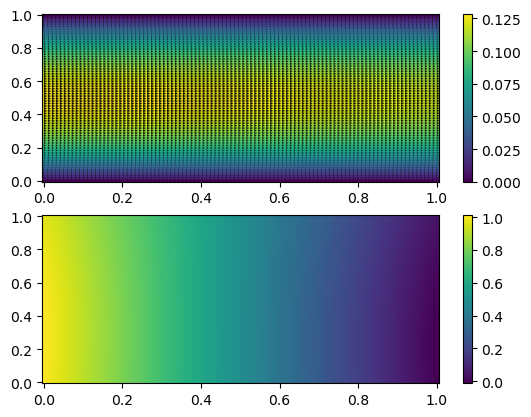

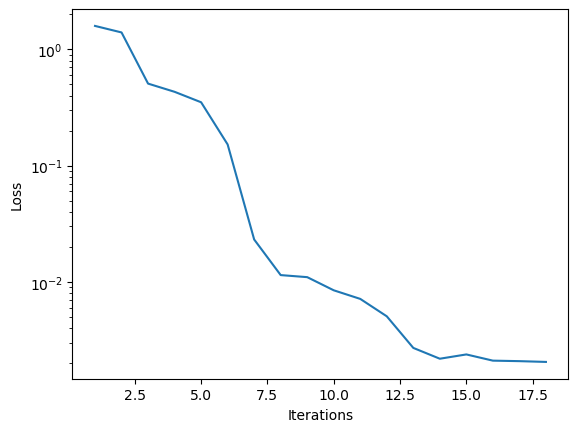

In [10]:
viz(u, p, epoch_loss)

Note that we haven't done anything about the boundary condition $u \times \nu$ and still get away with reasonably good looking solution having linearly dropping pressure and velocity with parabolic profile in $x$ and no flow in $y$ direction.